# Shifted Mean MIL Dataset

This notebook demonstrates the `ShiftedMeanMILDataset`, a synthetic MIL dataset where positive bags contain a contiguous sequence of instances with shifted mean features. This creates correlation between instance labels within positive bags, which is useful for testing MIL algorithms' ability to detect local patterns.

The dataset was introduced in: ["Synthetic Data Reveals Generalization Gaps in Correlated Multiple Instance Learning"](https://arxiv.org/abs/2510.25759)

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchmetrics
from torchmil.datasets.corr_toy_dataset import ShiftedMeanMILDataset, normal_pdf

plt.rcParams.update({"font.size": 10})

## Dataset Creation and Basic Usage

Let's create a small dataset and explore its structure:

In [ ]:
dataset = ShiftedMeanMILDataset(
    N=4,  # Number of bags
    R=3,  # Number of contiguous shifted instances in positive bags
    S_low=6,  # Minimum bag size
    S_high=9,  # Maximum bag size
    K=1,  # Number of features to shift
    M=1,  # Total number of features (1 for visualization)
    p_y1=0.5,  # Probability of positive bag
    Delta=1.0,  # Shift amount
    mu=0.0,  # Mean of normal distribution
    sigma=1.0,  # Standard deviation
    seed=2,  # Random seed for reproducibility
)

print(f"Dataset has {len(dataset)} bags\n")

# Explore the first bag
bag = dataset[0]
print("First bag contents:")
print(f"  Keys: {list(bag.keys())}")
print(f"  X shape: {bag['X'].shape}")
print(f"  Y (bag label): {bag['Y'].item()}")
print(f"  y_inst (instance labels): {bag['y_inst']}")
print(f"  bag_size: {bag['bag_size'].item()}")

Dataset has 4 bags

First bag contents:
  Keys: ['X', 'Y', 'y_inst', 'bag_size']
  X shape: torch.Size([6, 1])
  Y (bag label): 0
  y_inst (instance labels): tensor([0, 0, 0, 0, 0, 0])
  bag_size: 6


## Visualizing the Dataset

Let's visualize how the shifted mean creates correlation in positive bags:

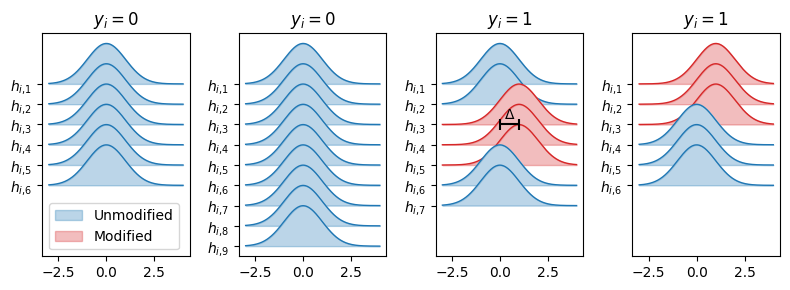

In [ ]:
ncols, nrows = 4, 1
fig, axs = plt.subplots(figsize=(2 * ncols, 3 * nrows), ncols=ncols, nrows=nrows)

offset = 0.2

for i in range(dataset.N):
    bag = dataset[i]
    X = bag["X"]
    Y = bag["Y"]
    y_inst = bag["y_inst"]
    bag_size = bag["bag_size"].item()

    for j in range(bag_size):
        # Check if this instance is shifted (has label 1)
        is_modified = (y_inst[j] == 1).item()
        color = "#D62728" if is_modified else "#1F77B4"

        # Create probability density curves
        x_axis = torch.linspace(start=-3, end=3 + dataset.Delta, steps=1000)
        if is_modified:
            y_axis = normal_pdf(x_axis, dataset.Delta, 1)
        else:
            y_axis = normal_pdf(x_axis, 0, 1)

        y_offset = (max(dataset.lengths) * offset) - (j * offset)
        axs[i].fill_between(
            x_axis, y_offset, y_axis + y_offset, alpha=1.0, color="#FFFFFF", zorder=0
        )
        axs[i].fill_between(
            x_axis, y_offset, y_axis + y_offset, alpha=0.3, color=color, zorder=0
        )
        axs[i].plot(x_axis, y_axis + y_offset, color=color, linewidth=1, zorder=0)

    axs[i].scatter(0, offset, alpha=0.0)
    axs[i].set_yticks(
        [(max(dataset.lengths) * offset) - (j * offset) for j in range(bag_size)]
    )
    axs[i].set_yticklabels([rf"$h_{{i,\!{j}}}$" for j in range(1, bag_size + 1)])
    axs[i].set_title(rf"$y_i={Y.item()}$")

# Find first positive bag for Delta annotation
positive_bags = [i for i in range(dataset.N) if dataset[i]["Y"] == 1]
if positive_bags:
    i = positive_bags[0]
    bag = dataset[i]
    y_inst = bag["y_inst"]

    # Find where the shifted instances start
    shifted_indices = torch.where(y_inst == 1)[0]
    if len(shifted_indices) > 0:
        first_shifted = shifted_indices[0].item()

        x0, x1 = 0, dataset.Delta
        y0 = (max(dataset.lengths) * offset) - (first_shifted * offset)
        axs[i].vlines(x0, y0 - 0.05, y0 + 0.05, color="#000000")
        axs[i].hlines(y0, x0, x1, color="#000000")
        axs[i].vlines(x1, y0 - 0.05, y0 + 0.05, color="#000000")
        axs[i].text((x0 + x1) / 2, y0 + 0.05, r"$\Delta$", ha="center")


axs[0].fill_between([], [], [], alpha=0.3, color="#1F77B4", label="Unmodified")
axs[0].fill_between([], [], [], alpha=0.3, color="#D62728", label="Modified")
axs[0].legend(loc="lower left")

fig.tight_layout()
plt.show()

## Bayes Optimal Classifier Performance

The dataset includes a method to compute the Bayes optimal classifier prediction. Let's evaluate its performance for different values of Delta:

Bayes Optimal AUROC for different Delta values:
  Delta=0.5: AUROC=0.5717
  Delta=1.0: AUROC=0.7119
  Delta=1.5: AUROC=0.8305
  Delta=2.0: AUROC=0.9219
  Delta=2.5: AUROC=0.9773
  Delta=3.0: AUROC=0.9971
  Delta=3.5: AUROC=1.0000
  Delta=4.0: AUROC=1.0000
  Delta=4.5: AUROC=1.0000
  Delta=5.0: AUROC=1.0000


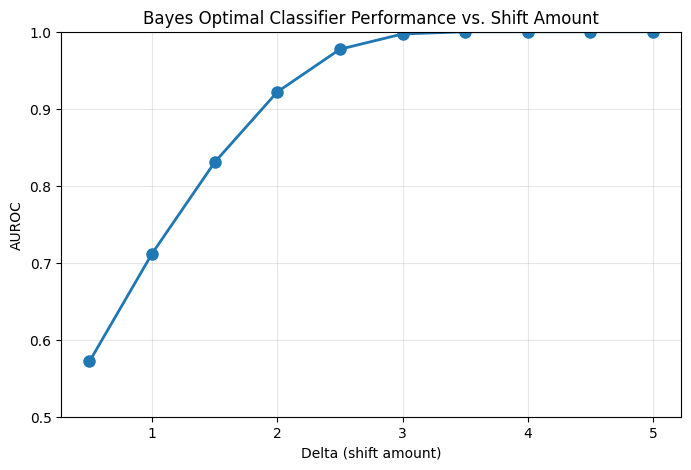

In [ ]:
auroc = torchmetrics.AUROC(task="binary")

Deltas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
bayes_aurocs = []

for Delta in Deltas:
    # Create test dataset with specific Delta
    test_dataset = ShiftedMeanMILDataset(N=100, R=3, Delta=Delta, seed=2)

    # Compute Bayes optimal predictions
    bayes_probs = torch.stack(
        [test_dataset.p_y1_given_h(i) for i in range(len(test_dataset))]
    )

    # Get true labels from the dataset
    true_labels = torch.stack([test_dataset[i]["Y"] for i in range(len(test_dataset))])

    # Compute AUROC
    bayes_aurocs.append(auroc(bayes_probs, true_labels).item())


plt.figure(figsize=(8, 5))
plt.plot(Deltas, bayes_aurocs, "o-", linewidth=2, markersize=8)
plt.xlabel("Delta (shift amount)")
plt.ylabel("AUROC")
plt.title("Bayes Optimal Classifier Performance vs. Shift Amount")
plt.grid(True, alpha=0.3)
plt.ylim([0.5, 1.0])

print("Bayes Optimal AUROC for different Delta values:")
for delta, auroc_val in zip(Deltas, bayes_aurocs):
    print(f"  Delta={delta:.1f}: AUROC={auroc_val:.4f}")

plt.show()